# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimisation

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


AMZN        BAC        COST         DIS         DPZ  \
Date                                                                     
2020-09-10  3175.110107  25.139999  339.529999  133.220001  388.201263   
2020-09-11  3116.219971  25.500000  339.130005  131.750000  393.899994   
2020-09-14  3102.969971  25.750000  342.920013  131.250000  388.519989   
2020-09-15  3156.129883  25.280001  343.910004  131.240005  389.519989   
2020-09-16  3078.100098  25.600000  343.730011  132.089996  385.980011   

                   KO         MCD        MSFT   NAT       SBUX  
Date                                                            
2020-09-10  49.598511  217.240005  205.369995  3.89  84.879997  
2020-09-11  50.650002  218.000000  204.029999  3.98  85.269997  
2020-09-14  50.709999  220.559998  205.410004  4.10  86.629997  
2020-09-15  51.049999  222.369995  208.779999  3.88  87.709999  
2020-09-16  50.790001  224.809998  205.050003  3.91  88.379997

In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    26.184059
1993-02-01    26.370279
1993-02-02    26.426161
1993-02-03    26.705482
1993-02-04    26.817228
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 1551746596864,
 'AMZN': 1541789450240,
 'NAT': 585287936,
 'BAC': 221974249472,
 'DPZ': 15187232768,
 'DIS': 238694547456,
 'KO': 218165395456,
 'MCD': 167281786880,
 'COST': 151765057536,
 'SBUX': 103316209664}

## Constructing the prior

In [6]:
import pypfopt
pypfopt.__version__

'1.2.5'

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5339776074163822

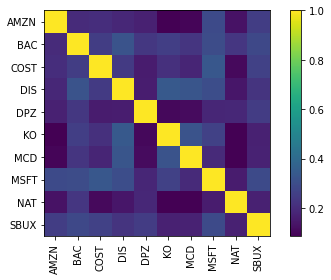

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.186858
BAC     0.099524
COST    0.073178
DIS     0.092603
DPZ     0.046718
KO      0.061815
MCD     0.067031
MSFT    0.125350
NAT     0.050667
SBUX    0.077876
dtype: float64

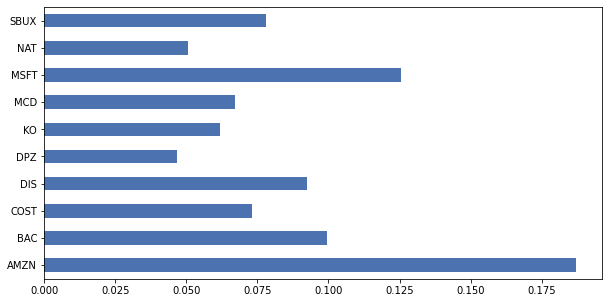

In [10]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [28]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

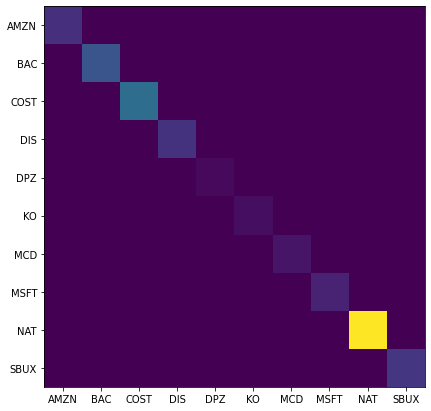

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.0045957 , 0.00904628, 0.01215225, 0.00497771, 0.00080327,
       0.00125644, 0.00197326, 0.00344742, 0.03408285, 0.00538662])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estiamte of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_averison="delta",
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.112406
BAC     0.147410
COST    0.052234
DIS     0.066644
DPZ     0.099961
KO      0.002566
MCD     0.106229
MSFT    0.094677
NAT     0.061849
SBUX    0.075419
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

Prior  Posterior  Views
AMZN  0.186858   0.112406   0.10
BAC   0.099524   0.147410   0.30
COST  0.073178   0.052234   0.05
DIS   0.092603   0.066644   0.05
DPZ   0.046718   0.099961   0.20
KO    0.061815   0.002566  -0.05
MCD   0.067031   0.106229   0.15
MSFT  0.125350   0.094677   0.10
NAT   0.050667   0.061849   0.50
SBUX  0.077876   0.075419   0.10

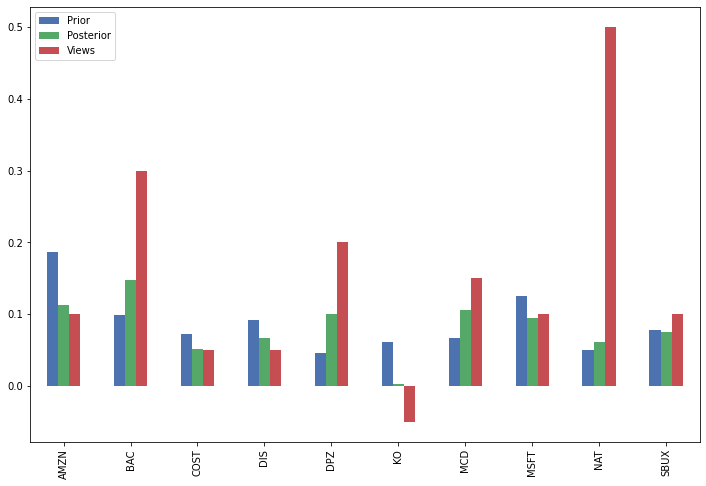

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is always between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

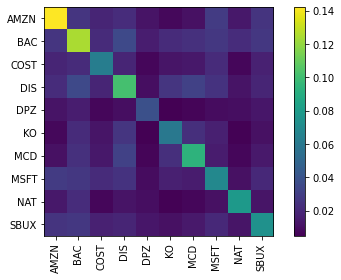

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\users\theod\anaconda3\envs\fe690\lib\site-packages\pypfopt\efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


OrderedDict([('AMZN', 0.14245),
             ('BAC', 0.20329),
             ('COST', 0.04405),
             ('DIS', 0.06203),
             ('DPZ', 0.14054),
             ('KO', 0.0),
             ('MCD', 0.14122),
             ('MSFT', 0.11906),
             ('NAT', 0.06391),
             ('SBUX', 0.08345)])

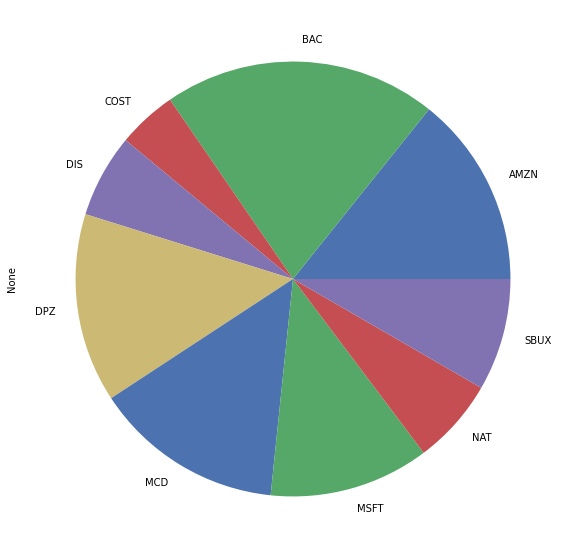

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $18.58


{'AMZN': 1,
 'BAC': 159,
 'COST': 3,
 'DIS': 9,
 'DPZ': 7,
 'MCD': 12,
 'MSFT': 11,
 'NAT': 327,
 'SBUX': 19}